# Obtaining LPC (Linear Prediction Coefficients) for speech command

In [32]:
import wave
import math
import cmath
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io.wavfile import read


%matplotlib inline

## Première Étape

### Plot préliminaire

/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  """


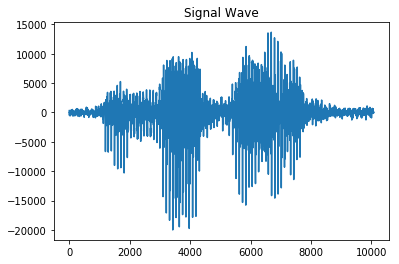

In [33]:
spf = wave.open('data/enavant.wav','r')

#Extract Raw Audio from Wav File
signal = spf.readframes(-1)
signal = np.fromstring(signal, 'Int16')


#If Stereo
if spf.getnchannels() == 2:
    print("Just mono files")
    sys.exit(0)

plt.figure(1)
plt.title('Signal Wave')
plt.plot(signal)
plt.show()

### Fichier Wave avec la librairie standard (voir plutot partie avec scipy)

In [34]:
signal_wave = wave.open("data/enavant.wav")

On va prendre des trames de 30 millisecondes, on veut donc des trames de (0.030 * 16000 =) 480 bytes.

In [35]:
def get_trames(signal, nbytes=480):
    (nchannels, sampwidth, framerate, nframes, comptype, compname) = signal.getparams()
    trames = []
    signal.rewind()
    while signal.tell() != nframes:
        trame = signal.readframes(nbytes)
        trames.append(trame)
    return trames

trames = get_trames(signal=signal_wave, nbytes=nbytes)

On a fini la première étape, on a décomposé notre signal en 21 trames de quelques dizaines de millisecondes.

Les 20 premières font 30 millisecondes, et la dernière est un peu plus courte.

### Utilisation de Scipy

Evaluation toutes les 10ms avec une fenêtre de 30ms

In [36]:
signal_wave = wave.open("data/enavant.wav")
(nchannels, sampwidth, framerate, nframes, comptype, compname) = signal_wave.getparams()

fe = framerate

[fs, a] = read("data/enavant.wav")
sig_in = np.array(a)

nbytes_fen = fs * 0.03 # 480
nbytes_pas = fs * 0.01 # 160

signals = []

for i in np.arange(0, len(sig_in), 160, dtype=int):
    signals.append(sig_in[i:i+480])
    
print(len(signals))

63


### Obtenir les coefficients à l' aide des signaux

Phi function (estimateur de la fonction d'autocorrélation du signal)

In [37]:
def phi(signal, k_ind):
    # phi est un estimateur de la fonction d'autocorrélation du signal
    N = len(signal)
    somme = 0
    for i in range(0, N - k_ind):
        somme += signal[i] * signal[i + k_ind]
    return (somme / N)

Algorithme pour un signal

In [38]:
def params_signal(signal, K):

    alpha = []
    k = []
    # a est un tableau de tableau (taille croissante)
    a = []

    alpha.append(phi(signal, 0))
    if (phi(signal, 0) == 0):
        if (phi(signal, 1) == 0):
            k.append(0)
        else:
            print("Possible issue here")
            k.append(0)
    else:
        k.append(-phi(signal, 1) / phi(signal, 0))
    a.append([-k[0]])

    for n in range(1, K):
        alpha_val = alpha[n-1] * (1 - (k[n-1]**2))
        alpha.append(alpha_val)
        sum_int = 0
        for p in range(0, n):
            sum_int += a[n-1][p] * phi(signal, n - p)
        int_val = (phi(signal, n) - sum_int)
        if (alpha_val == 0):
            if (int_val == 0):
                k.append(0)
            else:
                print("Possible issue here")
                k.append(0)
        else:
            k.append((-1/alpha_val) * int_val)
        a_array = []
        for q in range(0, n):
            int_a_val = a[n-1][q] + k[n] * a[n-1][n-q-1]
            a_array.append(int_a_val)
        a_array.append( -k[n])
        a.append(a_array)
        
    return (alpha, k, a)

In [39]:
def dsp_calculation(signal, K, a, nu): 
    sum_sigma = 0
    for i in range(0, K):
        sum_sigma += a[K-1][i] * phi(signal, i)
    sigma_e = phi(signal, 0) - sum_sigma
    sum_den_dsp = 0
    for j in range(0, K):
        sum_den_dsp += a[K-1][j] * cmath.exp(2 * cmath.pi * nu * j * 1j)
    den_dsp = (abs(1 - sum_den_dsp))**2
    dsp = 0
    if (den_dsp != 0 and sigma_e != 0):
        dsp = sigma_e / den_dsp
    return dsp

/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in short_scalars
  


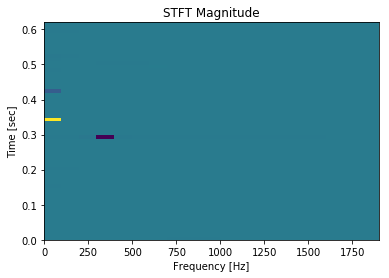

In [59]:
K = 10

alpha_arr = []
k_arr = []
a_arr = []
dsp_arr = []

t = np.arange(0, 0.01 * len(signals), 0.01)
f = range(0, 2000, 100)

# Il faut boucler sur tous les échantillons de notre son (rappel, on a pris des fenêtres de 30ms)
for i in range(0, len(signals)):
    [alpha, k, a] = params_signal(signals[i], K)
    alpha_arr.append(alpha)
    k_arr.append(k)
    a_arr.append(a)
    dsp_int_arr = []
    for j in f:
        nu = j / fe
        dsp = dsp_calculation(signals[i], K, a, nu)
        dsp_int_arr.append(dsp) 
    dsp_arr.append(dsp_int_arr)

plt.pcolormesh(f, t, dsp_arr)
plt.title('STFT Magnitude')
plt.ylabel('Time [sec]')
plt.xlabel('Frequency [Hz]')
plt.show()

### Obtenir les coefficients à l'aide de AudioLazy

In [49]:
def dsp_calculation_audiolazy(signal, K, a, nu): 
    sum_sigma = 0
    for i in range(0, K):
        sum_sigma += a[i] * phi(signal, i)
    sigma_e = phi(signal, 0) - sum_sigma
    sum_den_dsp = 0
    for j in range(0, K):
        sum_den_dsp += a[j] * cmath.exp(2 * cmath.pi * nu * j * 1j)
    den_dsp = (abs(1 - sum_den_dsp))**2
    dsp = 0
    if (den_dsp != 0 and sigma_e != 0):
        dsp = sigma_e / den_dsp
    return dsp

/usr/local/lib/python3.5/dist-packages/audiolazy/lazy_analysis.py:307: RuntimeWarning: overflow encountered in short_scalars
  return [sum(blk[n] * blk[n + tau] for n in xrange(len(blk) - tau))
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in short_scalars
  


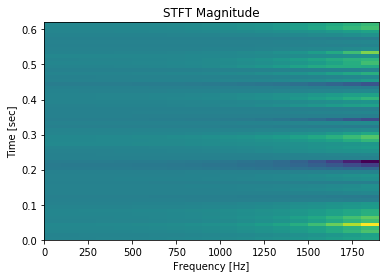

In [60]:
from audiolazy import lazy_lpc as lpc

K = 10

a_arr = []
dsp_arr = []

t = np.arange(0, 0.01 * len(signals), 0.01)
f = range(0, 2000, 100)

# Il faut boucler sur tous les échantillons de notre son (rappel, on a pris des fenêtres de 30ms)
for i in range(0, len(signals)):
    filt = lpc.lpc.kautocor(signals[i], K)
    # a = filt.numerator
    a = lpc.lsf(filt)
    a_arr.append(a)
    dsp_int_arr = []
    for j in f:
        nu = j / fe
        dsp = dsp_calculation_audiolazy(signals[i], K, a, nu)
        dsp_int_arr.append(dsp)
    dsp_arr.append(dsp_int_arr)

plt.pcolormesh(f, t, dsp_arr)
plt.title('STFT Magnitude')
plt.ylabel('Time [sec]')
plt.xlabel('Frequency [Hz]')
plt.show()
